## Plot results of multi-omics classification experiments

In these experiments, we compare elastic net logistic regression models using multiple data types to models using only a single data type. We're not doing anything particularly fancy here, just concatenating the feature sets (genes or CpG probes) from the individual data types to create a "multi-omics" model.

For now, we're just doing this for gene expression and the two methylation datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ttest_ind
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(
    cfg.results_dirs['multimodal'],
    # 'pilot_results',
    'pilot_results_all_feats',
    'gene'
).resolve()

# if True, save figures to ./images directory
SAVE_FIGS = True

### Compare raw results (signal and shuffled)

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# drop TET2 for now
results_df = results_df[~(results_df.identifier == 'TET2')].copy()

# make sure that we have data for all data types and for two replicates (random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.identifier.unique())
print(results_df.training_data.unique())
results_df.head()

(1152, 9)
[ 1 42]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k.me_450k' 'expression.me_27k'
 'me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.58776,0.53598,TP53,expression.me_450k,shuffled,1,train,0,gene
1,0.51092,0.45544,TP53,expression.me_450k,shuffled,1,test,0,gene
2,0.50821,0.47307,TP53,expression.me_450k,shuffled,1,cv,0,gene
3,0.52199,0.48146,TP53,expression.me_450k,shuffled,1,train,1,gene
4,0.51623,0.48159,TP53,expression.me_450k,shuffled,1,test,1,gene


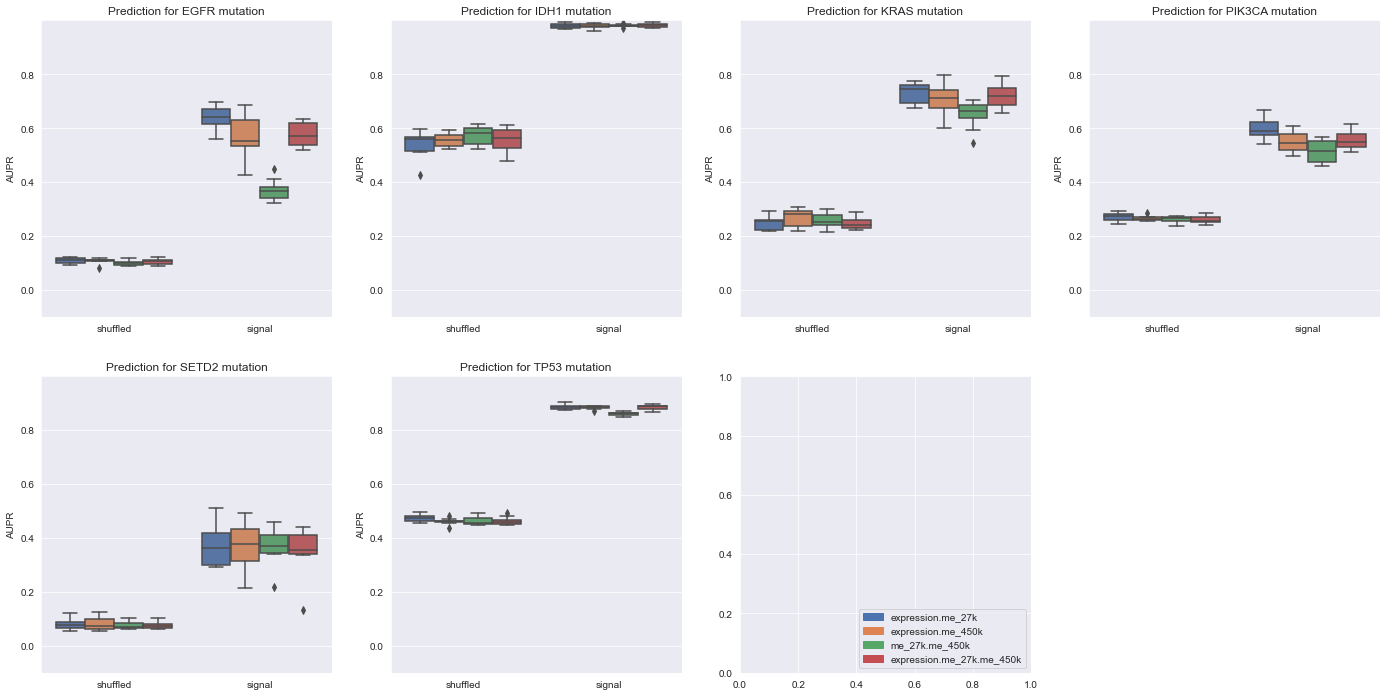

In [4]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (24, 12)})
fig, axarr = plt.subplots(2, 4)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)
max_aupr = results_df.aupr.max()

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

# plot mean performance over all genes in Vogelstein dataset
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 4, ix % 4]
    
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test')]

    sns.boxplot(data=plot_df, x='signal', y='aupr', hue='training_data',
                hue_order=data_order, ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_xlabel('')
    ax.set_ylabel('AUPR')
    ax.set_ylim(-0.1, max_aupr)
    ax.legend_.remove()
    
handles = []
for ix, data in enumerate(data_order):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)
    
fig.delaxes(axarr[1, 3])
plt.legend(handles=handles, loc='lower right')

### Compare single-omics and multi-omics results

In [5]:
# get results from unimodal prediction (individual data types) to compare with
# these are spread across 3 different results directories
# this is such a mess, I really need to clean up the results directories eventually

# expression, seed 1
unimodal_results_dir_1 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results',
    'gene'
)

# expression, seed 2
unimodal_results_dir_2 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results_2',
    'gene'
)

# me_27k, both seeds
unimodal_results_dir_3 = Path(
    cfg.results_dirs['mutation'],
    'bmiq_results_me_control',
    'gene'
)

# me_450k, both seeds
# use compressed data for this
unimodal_results_dir_4 = Path(
    cfg.results_dirs['mutation'],
    'compressed_results',
    'gene'
)

In [6]:
# load expression and me_27k results
u_results_df_1 = au.load_stratified_prediction_results(unimodal_results_dir_1, 'gene')
u_results_df_1 = u_results_df_1[(u_results_df_1.training_data == 'expression') &
                                (u_results_df_1.seed == 1)].copy()
u_results_df_2 = au.load_stratified_prediction_results(unimodal_results_dir_2, 'gene')
u_results_df_2 = u_results_df_2[u_results_df_2.training_data == 'expression'].copy()
u_results_df_3 = au.load_stratified_prediction_results(unimodal_results_dir_3, 'gene')

# load me_450k results
u_results_df_4 = au.load_compressed_prediction_results(unimodal_results_dir_4, 'gene',
                                                       old_filenames=True)
u_results_df_4 = u_results_df_4[(u_results_df_4.training_data == 'me_450k') &
                                (u_results_df_4.n_dims == 5000)].copy()
u_results_df_4.drop(columns='n_dims', inplace=True)

# make sure data loaded matches our expectations
print(u_results_df_1.training_data.unique())
print(u_results_df_2.training_data.unique())
print(u_results_df_3.training_data.unique())
print(u_results_df_4.training_data.unique())
print(u_results_df_1.seed.unique())
print(u_results_df_2.seed.unique())
print(u_results_df_3.seed.unique())
print(u_results_df_4.seed.unique())

['expression']
['expression']
['me_27k']
['me_450k']
[1]
[42]
[ 1 42]
[42  1]


In [7]:
# first, take the unimodal results and the multimodal results,
# and concatenate them into one giant results df
all_results_df = pd.concat((results_df,
                            u_results_df_1,
                            u_results_df_2,
                            u_results_df_3,
                            u_results_df_4))

print(all_results_df.shape)
print(all_results_df.training_data.unique())
all_results_df.head()

(15048, 9)
['expression.me_27k' 'expression.me_27k.me_450k' 'expression.me_450k'
 'me_27k.me_450k' 'expression' 'me_27k' 'me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.50000,0.104120,EGFR,expression.me_27k,shuffled,42,train,0,gene
1,0.50000,0.098765,EGFR,expression.me_27k,shuffled,42,test,0,gene
2,0.50531,0.104980,EGFR,expression.me_27k,shuffled,42,cv,0,gene
3,0.56624,0.147600,EGFR,expression.me_27k,shuffled,42,train,1,gene
4,0.50897,0.123030,EGFR,expression.me_27k,shuffled,42,test,1,gene


In [8]:
# then, for each training data type, get the AUPR difference between signal and shuffled
compare_df = pd.DataFrame()
for training_data in all_results_df.training_data.unique():
    data_compare_df = au.compare_control_ind(
        all_results_df[all_results_df.training_data == training_data],
        identifier='identifier',
        metric='aupr',
        verbose=True
    )
    data_compare_df['training_data'] = training_data
    data_compare_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_df = pd.concat((compare_df, data_compare_df))
    
compare_df.head(10)

shapes unequal for ACVR1B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping
shapes unequal for TSHR, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for CYLD, skipping
shapes unequal for HIST1H3B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PTPN11, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CYLD, skipping
shapes unequal for MLH1, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping


,gene,seed,fold,delta_aupr,training_data
0,EGFR,42,0,0.462095,expression.me_27k
1,EGFR,42,1,0.575210,expression.me_27k
2,EGFR,42,2,0.546220,expression.me_27k
3,EGFR,42,3,0.511270,expression.me_27k
4,EGFR,1,0,0.529412,expression.me_27k
5,EGFR,1,1,0.493000,expression.me_27k
6,EGFR,1,2,0.541130,expression.me_27k
7,EGFR,1,3,0.583159,expression.me_27k
8,IDH1,42,0,0.463950,expression.me_27k
9,IDH1,42,1,0.377540,expression.me_27k


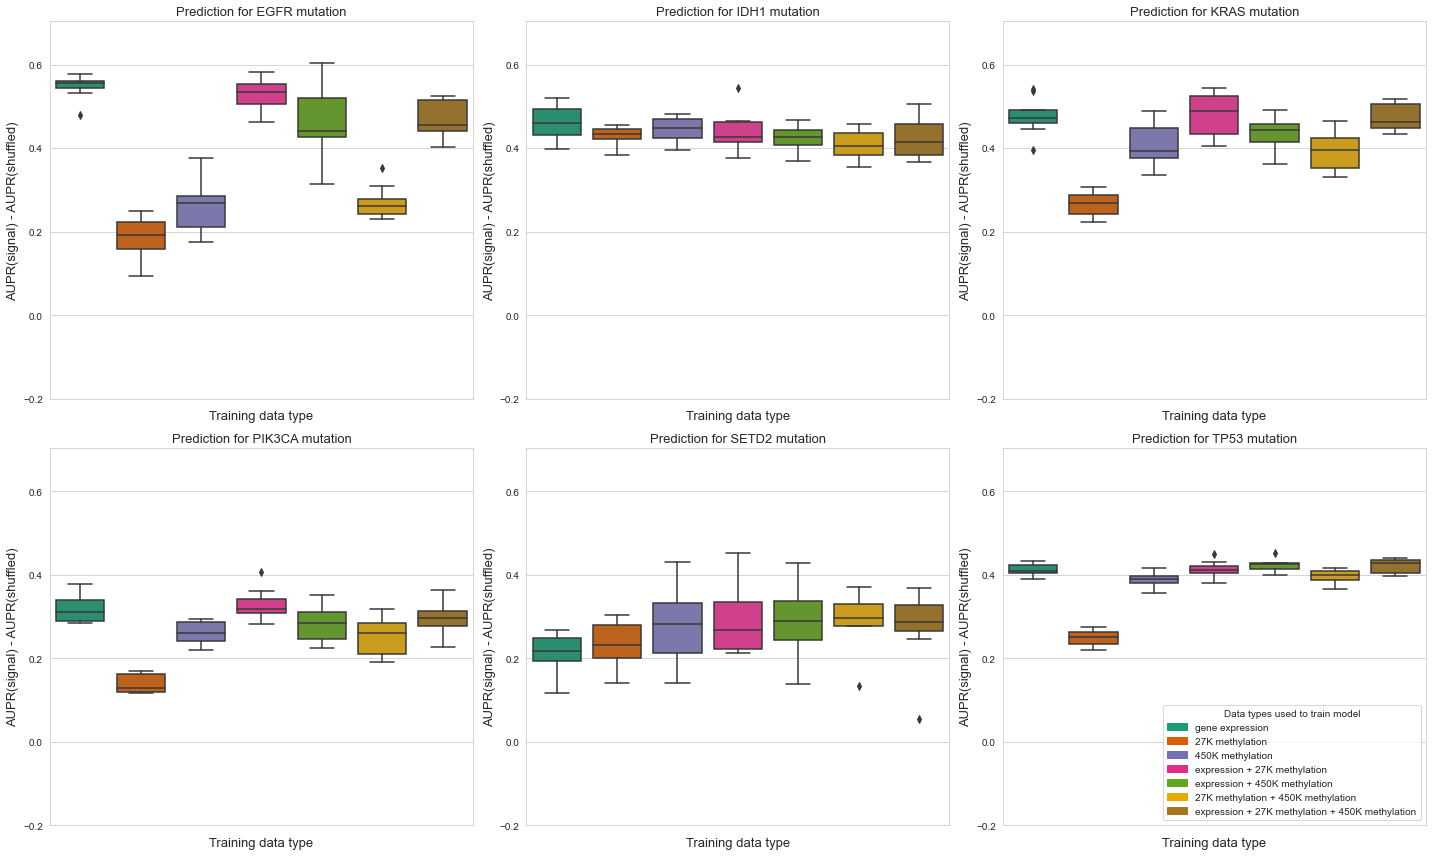

In [9]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 12)})
sns.set_style('whitegrid')
sns.set_palette('Dark2')

# fig, axarr = plt.subplots(2, 4)
fig, axarr = plt.subplots(2, 3)
compare_df.sort_values(by=['gene', 'training_data'], inplace=True)
compare_map = {v: str(i) for i, v in enumerate(compare_df.training_data.unique())}
min_aupr = compare_df.delta_aupr.min()
max_aupr = compare_df.delta_aupr.max()

data_names = {
    'expression': 'gene expression',
    'me_27k': '27K methylation',
    'me_450k': '450K methylation',
    'expression.me_27k': 'expression + 27K methylation',
    'expression.me_450k': 'expression + 450K methylation',
    'me_27k.me_450k': '27K methylation + 450K methylation',
    'expression.me_27k.me_450k': 'expression + 27K methylation + 450K methylation'
}

# plot mean performance over all genes in pilot experiment
for ix, gene in enumerate(results_df.identifier.unique()):
    
    ax = axarr[ix // 3, ix % 3]
    
    plot_df = compare_df[(compare_df.gene == gene)].copy()
    plot_df.training_data.replace(data_names, inplace=True)

    sns.boxplot(data=plot_df, x='training_data', y='delta_aupr',
                order=list(data_names.values()), ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene), size=13)
    ax.set_xlabel('Training data type', size=13)
    # hide x-axis tick text
    ax.get_xaxis().set_ticklabels([])
    ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
    ax.set_ylim(-0.2, max_aupr)
    
handles = []
for ix, data in enumerate(list(data_names.values())):
    handle = mpatches.Patch(color=sns.color_palette()[ix], label=data)
    handles.append(handle)
    
plt.legend(title='Data types used to train model', handles=handles, loc='lower right')
plt.tight_layout()

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['multimodal'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'multi_omics_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'multi_omics_boxes.png',
                dpi=300, bbox_inches='tight')

### Compare best-performing single-omics and multi-omics data types

In [10]:
# for each data type, classify it as single-omics or multi-omics
compare_df['model_type'] = 'Best single-omics'
# multi-omics data types are concatenated using dots
compare_df.loc[compare_df.training_data.str.contains('\.'), 'model_type'] = 'Best multi-omics'
print(compare_df.training_data.unique())
compare_df[compare_df.gene == 'TP53'].head(10)

['expression' 'me_27k' 'me_450k' 'expression.me_27k'
 'expression.me_27k.me_450k' 'expression.me_450k' 'me_27k.me_450k']


,gene,seed,fold,delta_aupr,training_data,model_type
704,TP53,1,0,0.40978,expression,Best single-omics
705,TP53,1,1,0.40749,expression,Best single-omics
706,TP53,1,2,0.40269,expression,Best single-omics
707,TP53,1,3,0.43339,expression,Best single-omics
708,TP53,42,0,0.42613,expression,Best single-omics
709,TP53,42,1,0.42219,expression,Best single-omics
710,TP53,42,2,0.40556,expression,Best single-omics
711,TP53,42,3,0.38959,expression,Best single-omics
40,TP53,42,0,0.41009,expression.me_27k,Best multi-omics
41,TP53,42,1,0.44884,expression.me_27k,Best multi-omics


EGFR diff: 0.0163 (pval: 0.3766)
IDH1 diff: 0.0187 (pval: 0.4427)
KRAS diff: -0.0051 (pval: 0.8444)
PIK3CA diff: -0.0109 (pval: 0.5544)
SETD2 diff: -0.0147 (pval: 0.7544)
TP53 diff: -0.0111 (pval: 0.1593)


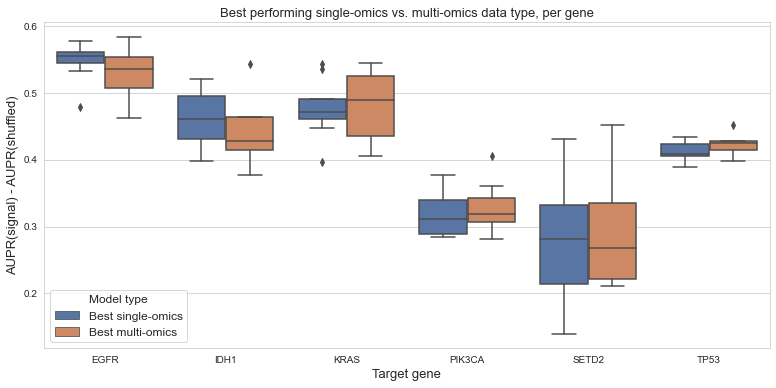

In [13]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')

plot_df = pd.DataFrame()

# plot mean performance over all genes in pilot experiment
for ix, gene in enumerate(results_df.identifier.unique()):
    
    plot_gene_df = compare_df[(compare_df.gene == gene)].reset_index(drop=True)
    
    # get the best-performing data types from the single-omics and multi-omics models
    max_single_data_type = (
        plot_gene_df[plot_gene_df.model_type.str.contains('single-omics')]
          .groupby('training_data')
          .agg('mean')
          .delta_aupr.idxmax()
    )
    max_multi_data_type = (
        plot_gene_df[plot_gene_df.model_type.str.contains('multi-omics')]
          .groupby('training_data')
          .agg('mean')
          .delta_aupr.idxmax()
    )
    
    # get samples with that data type
    max_single_df = plot_gene_df[plot_gene_df.training_data == max_single_data_type]
    max_multi_df = plot_gene_df[plot_gene_df.training_data == max_multi_data_type]
    
    # calculate difference between means and t-test p-val for that data type
    mean_diff = max_single_df.delta_aupr.mean() - max_multi_df.delta_aupr.mean()
    _, p_val = ttest_ind(max_single_df.delta_aupr.values,
                         max_multi_df.delta_aupr.values)
    print('{} diff: {:.4f} (pval: {:.4f})'.format(gene, mean_diff, p_val))
    
    plot_df = pd.concat((plot_df, max_single_df, max_multi_df))

sns.boxplot(data=plot_df, x='gene', y='delta_aupr', hue='model_type')
plt.title('Best performing single-omics vs. multi-omics data type, per gene', size=13)
plt.xlabel('Target gene', size=13)
plt.ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
plt.legend(title='Model type', loc='lower left', fontsize=12, title_fontsize=12)

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['multimodal'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'multi_omics_best_model.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'multi_omics_best_model.png',
                dpi=300, bbox_inches='tight')